### Tag clusters, visualize and extract key phrases and their associated sentences

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import ast
from nltk.tokenize import sent_tokenize
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
articles = pd.read_csv("../dataset/articles_with_cluster_labels.csv")

In [5]:
articles.columns

Index(['Microsoft Academic Paper ID', 'WHO #Covidence', 'authors', 'doi',
       'doi_url', 'has_full_text', 'journal', 'license', 'pmcid',
       'publish_time', 'pubmed_id', 'sha', 'source_x', 'source', 'title',
       'abstract', 'text_body', 'all_text', 'processed_text', 'key_phrases',
       'total_chars', 'lemmatized_preprocessed_text', 'log_total_words',
       'log_total_key_phrases', 'cluster_label', 'embedding_X', 'embedding_Y'],
      dtype='object')

#### Functions for processing and plotting

In [115]:
def tokenize_sents(text):
    return sent_tokenize(text)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], int(point['val']),fontsize=14)
        
def keyword_in_sentences(row):
    
    key_phrase = str(row["key_phrases"])
    sents = []
    for i, sent in enumerate(row['tokenized_sentences']):
        s = sent.lower()
        if key_phrase in s:
            sents.append((i,sent))
    
    return sents

def common_keyphrases_per_cluster(df,n_most_common=10):
    
    '''
    Get the most common key phrases per cluster and the sentences that they
    occur in
    '''
    
    for cluster_label in pd.unique(df['cluster_label']):
    
        if cluster_label > 0:
            
            print("MOST COMMON PHRASES IN CLUSTER {}".format(cluster_label))

            cluster_fname = "%02d_cluster_v2.csv" %cluster_label

            cluster = df[df["cluster_label"]==cluster_label]

            cluster['key_phrases'] = cluster['key_phrases'].apply(lambda x: ast.literal_eval(x))

            exploded_phrases = cluster[["key_phrases","sha","tokenized_sentences"]].explode("key_phrases")

            most_common_phrases = exploded_phrases.groupby("key_phrases").\
                    agg({"sha":"count"}).\
                    reset_index().\
                    sort_values(by="sha",ascending=False).\
                    rename(columns={"sha":"total_mentions"})

            limit_common_phrases = most_common_phrases.reset_index(drop=True).iloc[:n_most_common]

            grouped_phrases = limit_common_phrases.merge(exploded_phrases,on="key_phrases",how="inner")
            grouped_phrases["containing_sentences"] = grouped_phrases.apply(keyword_in_sentences,axis=1)

            list_of_ids = grouped_phrases.groupby("key_phrases")["sha"].apply(list)
            list_of_sents = grouped_phrases.groupby("key_phrases")["containing_sentences"].apply(list)

            list_common_phrases = grouped_phrases.groupby("key_phrases").\
                    agg({"sha":"nunique","total_mentions":"max",}).\
                    rename(columns={"sha":"total_sentences_mentioned"}).\
                    reset_index()

            list_common_phrases = list_common_phrases.merge(list_of_sents,on="key_phrases").\
                         merge(list_of_ids,on="key_phrases").\
                         sort_values(by="total_mentions",ascending=False).\
                         reset_index(drop=True)
            
            print(list_common_phrases.head())

            list_common_phrases.to_csv(cluster_fname,index=False)

In [97]:
articles["tokenized_sentences"] = articles["all_text"].apply(tokenize_sents)

In [98]:
umap_labels = articles['cluster_label']
umap_X = articles["embedding_X"]
umap_Y = articles["embedding_Y"]

In [99]:
mean_values_embedded = articles[["cluster_label","embedding_X","embedding_Y"]].\
            groupby("cluster_label").\
            agg({"embedding_X":["mean","std"],"embedding_Y":["mean","std"]}).\
            reset_index()

x_centroids = mean_values_embedded["embedding_X"]["mean"]
y_centroids = mean_values_embedded["embedding_Y"]["mean"]
centroid_labels = mean_values_embedded["cluster_label"]

In [100]:
deviations = (mean_values_embedded["embedding_X"]["std"] + mean_values_embedded["embedding_Y"]["std"])/2

#### Plot clusters of articles and circles corresponding to the standard deviations of their UMAP values

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


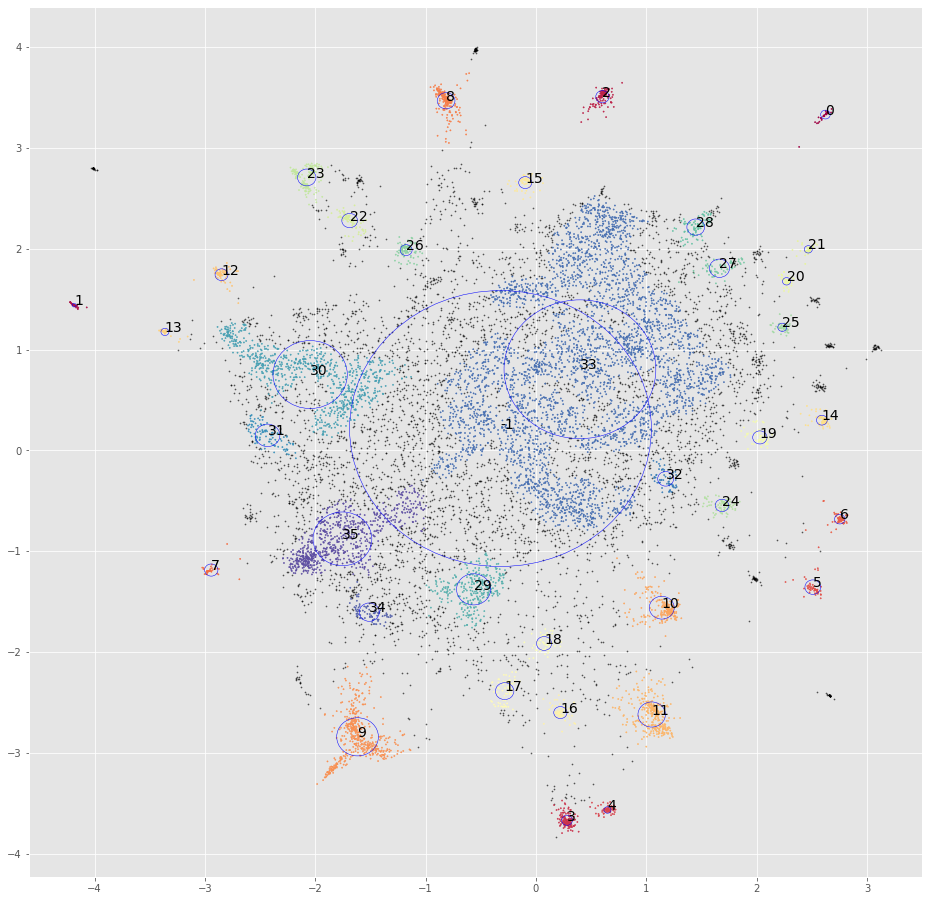

In [101]:
clustered = (umap_labels.values >= 0)
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)


ax.scatter(umap_X[~clustered],
            umap_Y[~clustered],
            c=(0, 0, 0),
            s=1.5,
            alpha=0.5)
ax.scatter(umap_X[clustered],
            umap_Y[clustered],
            c=umap_labels[clustered],
            s=1.5,
            cmap='Spectral');

label_point(x_centroids,y_centroids,centroid_labels,ax)

for (x,y,z) in zip(x_centroids,y_centroids,deviations):
    c1 = plt.Circle((x, y), z, color='b', fill=False)
    ax.add_artist(c1)

In [114]:
common_keyphrases_per_cluster(articles)

MOST COMMON PHRASES IN CLUSTER 16


/Users/rmartinshort/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


           key_phrases  total_sentences_mentioned  total_mentions  \
0               ang ii                         32              32   
1  converting enzyme 2                         31              31   
2       angiotensin ii                         25              25   
3   angiotensin system                         25              25   
4              table 1                         25              25   

                                containing_sentences  \
0  [[(7, Of the biologically active peptides that...   
1  [[(0, Angiotensin-converting enzyme 2 (ACE2) a...   
2  [[(31, In the case of SARS-CoV and bat/civet S...   
3  [[(46, This suggests that excessive ACE2 may c...   
4  [[(23, 1a showed that ACE2 could be expressed ...   

                                                 sha  
0  [98d83658e5a7c2174de3524a9a3b7c057a34b085, 989...  
1  [c630ebcdf30652f0422c3ec12a00b50241dc9bd9, 489...  
2  [4faf34d795e5ff74a886528e46268af783fe712b, 267...  
3  [c630ebcdf30652f0422c3ec1